# Graph-theoretical properties of the brain structural network

#### Importing Modules

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from collections import Counter
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import scipy.stats as stats
import math
from collections import defaultdict

#from backboning import high_salience_skeleton, read
from matplotlib.colors import ListedColormap, BoundaryNorm

import os
from pylab import *

%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

#### Helper Functions

In [81]:
def plot_histogram_kde_avg(patient_data, column_name):
    fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # Creating a 1x3 grid of subplots
    axs = axs.flatten()  # Flattening the 1x3 grid to one-dimensional array for easier iteration

    # Ignore the specific warning related to use_inf_as_na option
    warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

    for i, ax in enumerate(axs):
        # Assuming patient_data is structured correctly to use the following indexing
        data = patient_data[patient_data[f'group_{i+1}'] == 1][column_name]
        
        # Creating histogram
        ax.hist(data, bins=10, color='silver', edgecolor='black', density=True)
        ax.set_xlabel('Average Shortest Path Length')
        
        # Adding KDE plot
        sns.kdeplot(data, color='darkred', linestyle='dashdot', label='KDE', linewidth=1, ax=ax)
        
        # Adding a vertical line for the mean
        ax.axvline(x=np.mean(data), color='goldenrod', label='Mean', linewidth=3, linestyle='dotted')
        
        # Grid and other aesthetics
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()
        
        # Title for each subplot
        ax.set_title(f"Group {i+1}")

    #plt.tight_layout()
    plt.show()

In [82]:
def plot_histogram_kde(patient_data, column_name):
    fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # Creating a 1x3 grid of subplots
    axs = axs.flatten()  # Flattening the 1x3 grid to one-dimensional array for easier iteration
    warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
    for i, ax in enumerate(axs):
        # Assuming patient_data is structured correctly to use the following indexing
        data = []
        for k in patient_data[patient_data[f'group_{i+1}'] == 1][column_name]:
            data += [list(k.values())]

        data = [item for sublist in data for item in sublist]

        # Creating histogram
        ax.hist(data, bins=10, color='silver', edgecolor='black', density=True)
        ax.set_xlabel(column_name.split('_')[0] + ' ' + column_name.split('_')[1])
        
        # Adding KDE plot
        sns.kdeplot(data, color='darkred', linestyle='dashdot', label='KDE', linewidth=1, ax=ax)
        
        # Adding a vertical line for the mean
        ax.axvline(x=np.mean(data), color='goldenrod', label='Mean', linewidth=3, linestyle='dotted')
        
        # Grid and other aesthetics
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()
        
        # Title for each subplot
        ax.set_title(f"Group {i+1}")

    plt.show()

In [4]:
def disparity_filter(graph, alpha=0.01):
    """Apply the disparity filter to extract the backbone of the network."""
    if not nx.get_edge_attributes(graph, 'weight'):
        raise nx.NetworkXError("Graph does not contain 'weight' attribute on edges.")
    
    backbone = nx.Graph()
    for node in graph.nodes():
        k = len(graph[node])
        if k > 1:
            sum_w = sum([graph[node][nbr]['weight'] for nbr in graph[node]])
            for nbr in graph[node]:
                w = graph[node][nbr]['weight']
                p = 1 - (1 - w / sum_w) ** (k - 1)
                alpha_prime = 1 - (1 - alpha) ** (1 / (k - 1))
                if p < alpha_prime:
                    backbone.add_edge(node, nbr, weight=w)
    
    # Add isolated nodes to the backbone
    for node in graph.nodes():
        if node not in backbone:
            backbone.add_node(node)
    return backbone

In [21]:
from pylab import *

def circular_graph(G, subject = 21, graph_type = 'graph_data'):
    # Define the left and right nodes based on the given mapping and invert the order of the right nodes
    left_nodes = [
        1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
        41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77,
        79, 81, 83, 85, 87, 89
    ]
    right_nodes = list(reversed([
        2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
        42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78,
        80, 82, 84, 86, 88, 90
    ]))
    
    nodes = left_nodes + right_nodes

    G = patient_data[graph_type][subject]
    # Ensure the graph has 'weight' attributes for the edges
    for u, v, data in G.edges(data=True):
        if 'weight' not in data:
            data['weight'] = 1.0  # Assign a default weight if none exists
            
    # Arrange nodes in a circular layout
    pos = nx.circular_layout(G)
    
    # Adjust positions to separate left and right nodes
    left_angle = np.linspace(0, np.pi, len(left_nodes), endpoint=False)
    right_angle = np.linspace(np.pi, 2 * np.pi, len(right_nodes), endpoint=False)
    
    for i, node in enumerate(left_nodes):
        pos[node] = [np.cos(left_angle[i]), np.sin(left_angle[i])]
    for i, node in enumerate(right_nodes):
        pos[node] = [np.cos(right_angle[i]), np.sin(right_angle[i])]
    
    # Rotate the graph by 90 degrees
    for node in pos:
        x, y = pos[node]
        pos[node] = [-y, x]
    
    # Node size based on degree
    node_size = 200

    # Normalize betweenness centrality for coloring
    bw_cent = nx.betweenness_centrality(G)
    
    # Normalize values for color mapping
    def normalize(values):
        max_val = max(values) if values else 1
        return [v / max_val for v in values]
    
    node_color =  ['red' if node in left_nodes else 'orange' for node in G.nodes]

    edge_betw = nx.edge_betweenness_centrality(G)

    edge_color = normalize([edge_betw[e] for e in G.edges()])
    
    fig, axes = plt.subplots(1,1, figsize=(11, 6))
    
    graph = nx.draw_networkx(G,
                 pos,
                 ax=axes,
                 with_labels=True,
                 width=0.5,
                 node_size=node_size,
                 node_color=node_color,
                 cmap='hot',
                 edge_color=edge_color,
                 edge_cmap=plt.cm.viridis_r)

    fig.colorbar(graph, ax=axes , fraction=0.046, pad=0.04, cmap = 'viridis')

    axes.set_title(f'Original Graph - subject: {subject}')
    
    # Add a legend to the first plot
    left_patch = plt.Line2D([0], [0], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
    right_patch = plt.Line2D([0], [0], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
    axes.legend(handles=[left_patch, right_patch], loc='best')
    
    return graph

In [95]:
def circular_multiple_graphs(subject= 21):
    
    # Define the left and right nodes based on the given mapping and invert the order of the right nodes
    left_nodes = [
        1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
        41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77,
        79, 81, 83, 85, 87, 89
    ]
    right_nodes = list(reversed([
        2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
        42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78,
        80, 82, 84, 86, 88, 90
    ]))
    
    # Combine left and right nodes for indexing
    nodes = left_nodes + right_nodes
    
    # Retrieve the graph data for the specified subject
    G = patient_data['graph_data'][subject]
    G_binary = patient_data['graph_data_binary'][subject]
    G_backbone = patient_data['graph_data_backbone'][subject]
    
    # Ensure the graph has 'weight' attributes for the edges
    for u, v, data in G.edges(data=True):
        if 'weight' not in data:
            data['weight'] = 1.0  # Assign a default weight if none exists
    
    # Arrange nodes in a circular layout
    pos = nx.circular_layout(G)
    
    # Adjust positions to separate left and right nodes
    left_angle = np.linspace(0, np.pi, len(left_nodes), endpoint=False)
    right_angle = np.linspace(np.pi, 2 * np.pi, len(right_nodes), endpoint=False)
    
    for i, node in enumerate(left_nodes):
        pos[node] = [np.cos(left_angle[i]), np.sin(left_angle[i])]
    for i, node in enumerate(right_nodes):
        pos[node] = [np.cos(right_angle[i]), np.sin(right_angle[i])]
    
    # Rotate the graph by 90 degrees
    for node in pos:
        x, y = pos[node]
        pos[node] = [-y, x]
    
    # Node size based on degree
    node_size = 200
    
    # Normalize betweenness centrality for coloring
    bw_cent = nx.betweenness_centrality(G)
    bw_cent_backbone = nx.betweenness_centrality(G_backbone)
    bw_cent_binary = nx.betweenness_centrality(G_binary)
    
    # Normalize values for color mapping
    def normalize(values):
        max_val = max(values) if values else 1
        return [v / max_val for v in values]
    
    node_color =  ['red' if node in left_nodes else 'orange' for node in G.nodes]
    node_color_backbone = ['red' if node in left_nodes else 'orange' for node in G_backbone.nodes]
    
    
    # Betweenness centrality for edge color
    edge_betw = nx.edge_betweenness_centrality(G)
    edge_betw_backbone = nx.edge_betweenness_centrality(G_backbone)
    edge_betw_binary = nx.edge_betweenness_centrality(G_binary)
    
    edge_color = normalize([edge_betw[e] for e in G.edges()])
    edge_color_backbone = normalize([edge_betw_backbone[e] for e in G_backbone.edges()])
    edge_color_binary = normalize([edge_betw_binary[e] for e in G_binary.edges()])
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Draw the original graph
    graph_1 = nx.draw_networkx(G,
                     pos,
                     ax=axes[0],
                     with_labels=True,
                     width=0.5,
                     node_size=node_size,
                     node_color=node_color,
                     cmap='hot',
                     edge_color=edge_color,
                     edge_cmap=plt.cm.viridis_r)
    fig.colorbar(graph_1, ax=axes[0] , fraction=0.046, pad=0.04, cmap = 'viridis')
    
    axes[0].set_title(f'Original Graph - subject: {subject}')
    
    # Draw the backboned graph
    graph_2 = nx.draw_networkx(G_backbone,
                     pos,
                     ax=axes[1],
                     with_labels=True,
                     width=0.5,
                     node_size=node_size,
                     node_color=node_color_backbone,
                     cmap='hot',
                     edge_color=edge_color_backbone,
                     edge_cmap=plt.cm.viridis_r)
    
    fig.colorbar(graph_2, ax=axes[1] , fraction=0.046, pad=0.04, cmap = 'viridis')
    
    axes[1].set_title(f'Backboned Graph - subject: {subject}')
    
    # Draw the binary graph
    graph_3 = nx.draw_networkx(G_binary,
                     pos,
                     ax=axes[2],
                     with_labels=True,
                     width=0.5,
                     node_size=node_size,
                     node_color=node_color,
                     cmap='hot',
                     edge_color=edge_color_binary,
                     edge_cmap=plt.cm.viridis_r)

    fig.colorbar(graph_3, ax=axes[2] , fraction=0.046, pad=0.04, cmap = 'viridis')
    
    axes[2].set_title(f'Threshold Graph - subject: {subject}')
    
    # Add a legend to the first plot
    left_patch = plt.Line2D([0], [0], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
    right_patch = plt.Line2D([0], [0], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
    axes[0].legend(handles=[left_patch, right_patch], loc='best')
    
    left_patch = plt.Line2D([1], [1], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
    right_patch = plt.Line2D([1], [1], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
    axes[1].legend(handles=[left_patch, right_patch], loc='best')
    
    left_patch = plt.Line2D([2], [2], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
    right_patch = plt.Line2D([2], [2], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
    axes[2].legend(handles=[left_patch, right_patch], loc='best')
    
    return None

In [24]:
def graph_4(graph_type = 'graph_data', subject = [21, 38, 54]):
    # Create a figure with a 3x3 grid of axes
    fig, axes = plt.subplots(1, 3, figsize=(11, 6))

    subject_ages = [19, 29, 45]
    
    left_nodes = [
        1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
        41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77,
        79, 81, 83, 85, 87, 89
    ]
    right_nodes = list(reversed([
        2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
        42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78,
        80, 82, 84, 86, 88, 90
    ]))
    
    # Loop over the grid and fill in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Set the current axis on which to draw
        plt.sca(ax)
    
        G = patient_data[graph_type][subjects[i]]
    
        # Combine left and right nodes for indexing
        nodes = left_nodes + right_nodes
    
        # Ensure the graph has 'weight' attributes for the edges
        for u, v, data in G.edges(data=True):
            if 'weight' not in data:
                data['weight'] = 1.0  # Assign a default weight if none exists
        
        # Arrange nodes in a circular layout
        pos = nx.circular_layout(G)
        
        # Adjust positions to separate left and right nodes
        left_angle = np.linspace(0, np.pi, len(left_nodes), endpoint=False)
        right_angle = np.linspace(np.pi, 2 * np.pi, len(right_nodes), endpoint=False)
        
        for l, node in enumerate(left_nodes):
            pos[node] = [np.cos(left_angle[l]), np.sin(left_angle[l])]
        for l, node in enumerate(right_nodes):
            pos[node] = [np.cos(right_angle[l]), np.sin(right_angle[l])]
        
        # Rotate the graph by 90 degrees
        for node in pos:
            x, y = pos[node]
            pos[node] = [-y, x]
        
        # Node size based on degree
        node_size = 200
        
        # Normalize betweenness centrality for coloring
        bw_cent = nx.betweenness_centrality(G)
        
        # Normalize values for color mapping
        def normalize(values):
            max_val = max(values) if values else 1
            return [v / max_val for v in values]
        
        node_color =  ['red' if node in left_nodes else 'orange' for node in G.nodes]
        
        
        # Betweenness centrality for edge color
        edge_betw = nx.edge_betweenness_centrality(G)
        
        edge_color = normalize([edge_betw[e] for e in G.edges()])
        
        
        # Draw the original graph
        graph = nx.draw_networkx(G,
                         pos,
                         ax=ax,
                         with_labels=True,
                         width=0.5,
                         node_size=node_size,
                         node_color=node_color,
                         cmap='hot',
                         edge_color=edge_color,
                         edge_cmap=plt.cm.viridis_r)

        fig.colorbar(graph, ax=ax , fraction=0.046, pad=0.04, cmap = 'viridis')
        
        #fig.colorbar(graph_1, ax=axes[0] , fraction=0.046, pad=0.04, cmap = 'viridis')
        left_patch = plt.Line2D([0], [0], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
        right_patch = plt.Line2D([0], [0], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
        ax.legend(handles=[left_patch, right_patch], loc='best')
    
        # Optionally set titles or labels
        subject_age = subject_ages[i]
        ax.set_title(f'Subject age - {subject_age}')
        #plt.axis('on')
    
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [25]:
def graph_4_avg(graph_type = 'graph_data'):
    # Create a figure with a 3x3 grid of axes
    fig, axes = plt.subplots(1, 3, figsize=(11, 6))

    subject_ages = ['18-25', '25-35', '35-45']
    
    left_nodes = [
        1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
        41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77,
        79, 81, 83, 85, 87, 89
    ]
    right_nodes = list(reversed([
        2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
        42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78,
        80, 82, 84, 86, 88, 90
    ]))
    
    # Loop over the grid and fill in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Set the current axis on which to draw
        plt.sca(ax)
        if graph_type == 'graph_binary':
            data = patient_data[patient_data[f'group_{i+1}'] == 1]['binary_matrix'].mean()
        else:
            data = patient_data[patient_data[f'group_{i+1}'] == 1]['adj_matrix'].mean()
    
        G = nx.from_numpy_array(data)
        G = nx.relabel_nodes(G, {i: i + 1 for i in G.nodes()})
    
        # Combine left and right nodes for indexing
        nodes = left_nodes + right_nodes
    
        # Ensure the graph has 'weight' attributes for the edges
        for u, v, data in G.edges(data=True):
            if 'weight' not in data:
                data['weight'] = 1.0  # Assign a default weight if none exists
        
        # Arrange nodes in a circular layout
        pos = nx.circular_layout(G)
        
        # Adjust positions to separate left and right nodes
        left_angle = np.linspace(0, np.pi, len(left_nodes), endpoint=False)
        right_angle = np.linspace(np.pi, 2 * np.pi, len(right_nodes), endpoint=False)
        
        for l, node in enumerate(left_nodes):
            pos[node] = [np.cos(left_angle[l]), np.sin(left_angle[l])]
        for l, node in enumerate(right_nodes):
            pos[node] = [np.cos(right_angle[l]), np.sin(right_angle[l])]
        
        # Rotate the graph by 90 degrees
        for node in pos:
            x, y = pos[node]
            pos[node] = [-y, x]
        
        # Node size based on degree
        node_size = 200
        
        # Normalize betweenness centrality for coloring
        bw_cent = nx.betweenness_centrality(G)
        
        # Normalize values for color mapping
        def normalize(values):
            max_val = max(values) if values else 1
            return [v / max_val for v in values]
        
        node_color =  ['red' if node in left_nodes else 'orange' for node in G.nodes]
        
        
        # Betweenness centrality for edge color
        edge_betw = nx.edge_betweenness_centrality(G)
        
        edge_color = normalize([edge_betw[e] for e in G.edges()])
        
        
        # Draw the original graph
        graph = nx.draw_networkx(G,
                         pos,
                         ax=ax,
                         with_labels=True,
                         width=0.5,
                         node_size=node_size,
                         node_color=node_color,
                         cmap='hot',
                         edge_color=edge_color,
                         edge_cmap=plt.cm.viridis_r)

        fig.colorbar(graph, ax=ax , fraction=0.046, pad=0.04, cmap = 'viridis')
        
        #fig.colorbar(graph_1, ax=axes[0] , fraction=0.046, pad=0.04, cmap = 'viridis')
        left_patch = plt.Line2D([0], [0], marker='o', color='w', label='Left Hemisphere', markersize=10, markerfacecolor='red')
        right_patch = plt.Line2D([0], [0], marker='o', color='w', label='Right Hemisphere', markersize=10, markerfacecolor='orange')
        ax.legend(handles=[left_patch, right_patch], loc='best')
    
        # Optionally set titles or labels
        subject_age = subject_ages[i]
        ax.set_title(f'Group {i+1} (age: {subject_age})')
        #plt.axis('on')
    
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [9]:
def unique_mode(df, cols):
    used = set()
    result = []
    for index, row in df[cols].iterrows():
        count = Counter(row)
        row_modes = [item for item, _ in count.most_common()]
        mode_value = next((val for val in row_modes if val not in used), None)
        result.append(mode_value)
        if mode_value is not None:
            used.add(mode_value)
    return pd.Series(result, index=df.index)

## Importing Data

In [26]:
folder_path = '/Users/lemon/Documents/Uni/Magistrale/Semestre 4/Simulation & Modeling/Research Project/Data/structural_connectivity_matrices'

numpy_arrays = []

file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
file_list.sort() 

# Loop through sorted list of files
for filename in file_list:
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path, header = None)  # Load the CSV into a DataFrame
    arr = df.to_numpy()  # Convert DataFrame to NumPy array
    numpy_arrays.append(arr)  # Append the array to the list

In [27]:
warnings.filterwarnings('ignore')

path_clinics = '/Users/lemon/Documents/Uni/Magistrale/Semestre 4/Simulation & Modeling/Research Project/Data/clinics.csv'
path_regions = '/Users/lemon/Documents/Uni/Magistrale/Semestre 4/Simulation & Modeling/Research Project/Data/AAL_regions.csv'
 
patient_data = pd.read_csv(path_clinics, sep = ';')

# Setting Subject as Index
patient_data.set_index(['subject'], inplace = True)

# Rounding the age
patient_data['age (years)'] = patient_data['age (years)'].apply(round)

# Flag for year range
patient_data['group_1'] = ((patient_data['age (years)'] >= 18) & (patient_data['age (years)'] < 25)).astype(int)
patient_data['group_2'] = ((patient_data['age (years)'] > 25) & (patient_data['age (years)'] <= 35)).astype(int)
patient_data['group_3'] = ((patient_data['age (years)'] > 35) & (patient_data['age (years)'] <= 50)).astype(int)

# Appending tje adj_matrix
patient_data['adj_matrix'] = numpy_arrays

# Creating graph Data
patient_data['graph_data'] = patient_data['adj_matrix'].apply(nx.from_numpy_array)

#disparity_filter(G, alpha=0.01)

#Creating bianry matrices
threshold = 0.01

binary_matrices = patient_data['adj_matrix'].apply(lambda x: x > threshold).apply(lambda x: x.astype(int))
patient_data['binary_matrix'] = binary_matrices
patient_data['graph_data_binary'] = patient_data['binary_matrix'].apply(nx.from_numpy_array)

patient_data['graph_data_binary'] = patient_data['binary_matrix'].apply(nx.from_numpy_array)

#patient_data['graph_data_backbone'] = 0

for l in range(1, len(patient_data) + 1):
    patient_data['graph_data'].loc[l] = nx.relabel_nodes(patient_data['graph_data'].loc[l], {i: i + 1 for i in patient_data['graph_data'].loc[l].nodes()})
    patient_data['graph_data_binary'].loc[l] = nx.relabel_nodes(patient_data['graph_data_binary'].loc[l], {i: i + 1 for i in patient_data['graph_data_binary'].loc[l].nodes()})

patient_data['graph_data_backbone'] = patient_data['graph_data'].apply(lambda x: disparity_filter(x, alpha=0.01))


brain_regions = pd.read_csv(path_regions, sep = ';')

In [28]:
patient_data.head()

gender  age (years)  right-handed                    education  \
subject                                                                   
1        female           25           1.0  bachelor's degree or higher   
2        female           28           1.0  bachelor's degree or higher   
3        female           34           1.0  bachelor's degree or higher   
4        female           29           1.0  bachelor's degree or higher   
5          male           32           1.0  bachelor's degree or higher   

         weight (kg)  height (m)    BMI  group_1  group_2  group_3  \
subject                                                              
1                 58        1.70  20.07        0        0        0   
2                 57        1.65  20.94        0        1        0   
3                 54        1.56  22.19        0        1        0   
4                 58        1.65  21.30        0        1        0   
5                 66        1.79  20.60        0        1        0   

                                                adj_matrix  \
subject                                                      
1        [[0.0, 0.0032767908, 0.0131601719, 0.010352149...   
2        [[0.0, 2.62295e-05, 0.0377538003, 0.0008467958...   
3        [[0.0, 3.45711e-05, 0.0558606914, 0.0016950064...   
4        [[0.0, 0.0013918506, 0.0398835314, 0.003167062...   
5        [[0.0, 5.63291e-05, 0.0505738397, 0.000807384,...   

                                                graph_data  \
subject                                                      
1        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                             binary_matrix  \
subject                                                      
1        [[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,...   
2        [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,...   
3        [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,...   
4        [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,...   
5        [[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,...   

                                         graph_data_binary  \
subject                                                      
1        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5        (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                       graph_data_backbone  
subject                                                     
1        (1, 9, 10, 16, 25, 44, 52, 90, 2, 6, 15, 26, 4...  
2        (1, 5, 30, 37, 43, 45, 46, 48, 50, 82, 86, 39,...  
3        (1, 6, 25, 26, 38, 39, 43, 46, 47, 52, 16, 2, ...  
4        (1, 5, 15, 27, 36, 39, 44, 45, 46, 47, 48, 49,...  
5        (1, 16, 18, 27, 38, 43, 46, 47, 50, 55, 86, 90...

In [29]:
patient_data['adj_matrix'].mean()

array([[0.00000000e+00, 9.35794761e-04, 2.70653980e-02, ...,
        5.31443182e-08, 1.34807528e-03, 4.47976136e-07],
       [8.97412249e-04, 0.00000000e+00, 7.44034234e-04, ...,
        8.90495682e-06, 1.26198295e-06, 5.16045888e-04],
       [2.12549847e-02, 3.95485916e-04, 0.00000000e+00, ...,
        2.94523864e-07, 1.17177772e-04, 1.13966477e-06],
       ...,
       [6.42886364e-08, 1.08526182e-05, 7.81398864e-07, ...,
        0.00000000e+00, 2.74077614e-06, 7.31346342e-02],
       [3.40777839e-04, 5.99734091e-07, 1.01398407e-04, ...,
        1.11770000e-06, 0.00000000e+00, 1.13367602e-05],
       [3.54993182e-07, 2.29695803e-04, 1.50581477e-06, ...,
        1.92054667e-02, 1.01535773e-05, 0.00000000e+00]])

In [30]:
brain_regions.loc[67]

ROI number             68
ROI name      R Precuneus
Name: 67, dtype: object

## Analyzing Patient Data (Gender and Age)

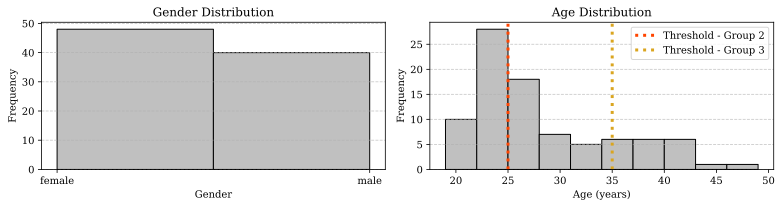

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

# First subplot: Histogram of gender
axs[0].hist(patient_data.gender, bins=2, color='silver', edgecolor='black')
axs[0].set_title('Gender Distribution')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Histogram of age
axs[1].hist(patient_data['age (years)'], bins=10, color='silver', edgecolor='black')
axs[1].set_title('Age Distribution')
axs[1].set_xlabel('Age (years)')
axs[1].set_ylabel('Frequency')
# Adding a vertical line for the mean
axs[1].axvline(x=25, color='orangered', label='Threshold - Group 2', linewidth=3, linestyle='dotted')  
axs[1].axvline(x=35, color='goldenrod', label='Threshold - Group 3', linewidth=3, linestyle='dotted')  

# Grid and other aesthetics
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend()

# Display the subplots
plt.tight_layout()
plt.show()

## Network Analytics - Single Individual

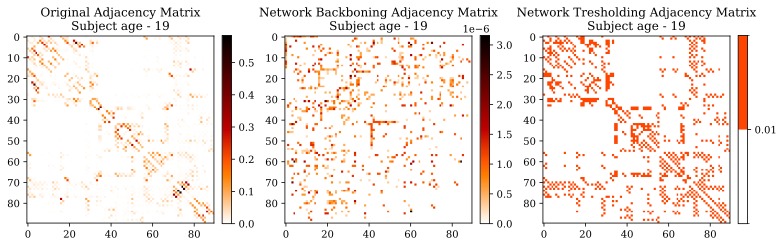

In [32]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats as stats
import math

# Define the left and right nodes based on the given mapping and invert the order of the right nodes
left_nodes = [
    1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
    41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77,
    79, 81, 83, 85, 87, 89
]
right_nodes = list(reversed([
    2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
    42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78,
    80, 82, 84, 86, 88, 90
]))

# Combine left and right nodes for indexing
nodes = left_nodes + right_nodes

# Retrieve the graph data for the specified subject
subject = 21
G = patient_data['graph_data'][subject]
G_binary = patient_data['graph_data_binary'][subject]
G_backbone = patient_data['graph_data_backbone'][subject]

# Ensure the graph has 'weight' attributes for the edges
for u, v, data in G.edges(data=True):
    if 'weight' not in data:
        data['weight'] = 1.0  # Assign a default weight if none exists

# Apply the disparity filter to get the backbone of the graph
#G_backbone = disparity_filter(G, alpha=0.01)

# Obtain the adjacency matrix of the original, backboned, and binary graphs
adj_matrix_original = nx.adjacency_matrix(G).todense()
adj_matrix_backbone = nx.adjacency_matrix(G_backbone).todense()
adj_matrix_binary = nx.adjacency_matrix(G_binary).todense()

# Optionally, convert the adjacency matrices to DataFrames for easier viewing
adj_matrix_original_df = pd.DataFrame(adj_matrix_original)
adj_matrix_backbone_df = pd.DataFrame(adj_matrix_backbone)
adj_matrix_binary_df = pd.DataFrame(adj_matrix_binary)

# Plot the original, backboned, and binary adjacency matrices side by side
fig, axs = plt.subplots(1, 3, figsize=(11, 6))  # Adjust the figure size as needed

original_colormap = plt.cm.viridis
inverted_colormap = plt.cm.get_cmap('gist_heat_r')

# Plot the heatmap of the original adjacency matrix
im1 = axs[0].imshow(adj_matrix_original_df, cmap=inverted_colormap, interpolation='nearest')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
subject_age = patient_data.loc[subject, 'age (years)']
# axs[0].set_xticks([])  # Remove x-axis ticks
# axs[0].set_yticks([])  # Remove y-axis ticks
axs[0].set_title(f'Original Adjacency Matrix\nSubject age - {subject_age}')

# Plot the heatmap of the backboned adjacency matrix
im2 = axs[1].imshow(adj_matrix_backbone_df, cmap=inverted_colormap, interpolation='nearest')
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
# axs[1].set_xticks([])  # Remove x-axis ticks
# axs[1].set_yticks([])  # Remove y-axis ticks
axs[1].set_title(f'Network Backboning Adjacency Matrix\nSubject age - {subject_age}')

# Plot the heatmap of the binary adjacency matrix

cmap = ListedColormap(['white', 'orangered'])
bounds = [0, threshold, 1]  # Data range split at 0.01
norm = BoundaryNorm(bounds, cmap.N)

im3 = axs[2].imshow(adj_matrix_binary_df, cmap=cmap, norm = norm, interpolation='nearest')
# Add a colorbar to each subplot, using the same norm and cmap
cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_ticks([threshold])  # Set specific ticks if desired
cbar.set_ticklabels([str(threshold)])  # Custom labels for the ticks
# axs[2].set_xticks([])  # Remove x-axis ticks
# axs[2].set_yticks([])  # Remove y-axis ticks
axs[2].set_title(f'Network Tresholding Adjacency Matrix\nSubject age - {subject_age}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


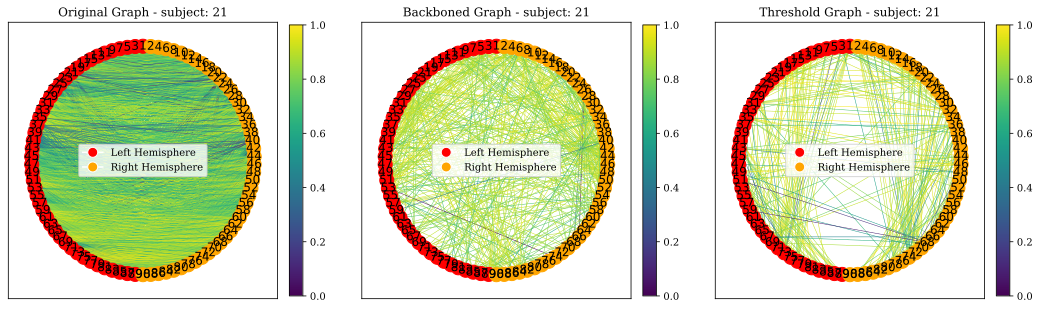

In [96]:
circular_multiple_graphs(subject = 21)

In [34]:
nx.average_shortest_path_length(G)

1.1862671660424469

count    90.000000
mean      0.813733
std       0.138546
min       0.415730
25%       0.744382
50%       0.853933
75%       0.921348
max       0.988764
Name: DegreeCentrality, dtype: float64
Top 5 nodes (degree centrality):
    Node  DegreeCentrality
35    36          0.988764
74    75          0.988764
75    76          0.988764
33    34          0.977528
71    72          0.977528


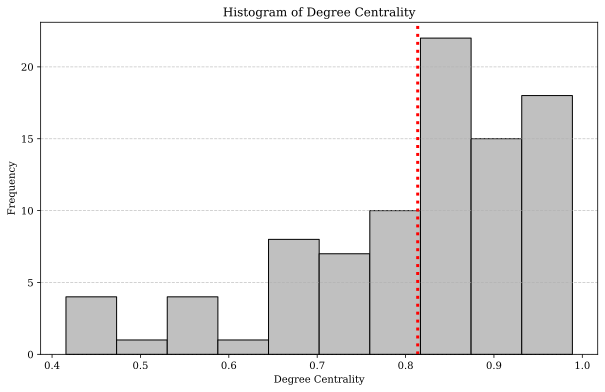

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Convert to DataFrame for easier analysis
centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'DegreeCentrality'])

# Summary statistics
summary_stats = centrality_df['DegreeCentrality'].describe()
print(summary_stats)

# Identify top 5 hubs
top_5_hubs = centrality_df.nlargest(5, 'DegreeCentrality')
print("Top 5 nodes (degree centrality):")
print(top_5_hubs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['DegreeCentrality'], bins=10, edgecolor='black', color = 'silver')
plt.title('Histogram of Degree Centrality')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.axvline(x=centrality_df['DegreeCentrality'].mean(), color='red', label='Mean', linewidth=3, linestyle='dotted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**The Graph**:

The histogram shows the distribution of degree centrality values across the nodes in the brain network. The x-axis represents the degree centrality values, while the y-axis represents the frequency of nodes having those centrality values.

**Observations**:
- Distribution: The histogram indicates that the degree centrality values are skewed towards higher values.
- Range: Degree centrality values range from approximately 0.4 to 1.0.
- Frequency: The most frequent degree centrality values are around 0.8 to 0.9, with fewer nodes having degree centrality values below 0.7.

**Implications**:
- High Connectivity: The skew towards higher degree centrality values suggests that many nodes in the network are highly connected. This is indicative of a well-integrated network with multiple hubs.
- Critical Nodes: Nodes with high degree centrality are crucial for maintaining network integrity and connectivity. They likely play significant roles in various brain functions by facilitating efficient communication between different brain regions.
- Network Robustness: The presence of many highly connected nodes implies a robust network. However, it also suggests that the removal of these nodes could have a significant impact on the network's overall connectivity.

**Network Characteristics**:

The high degree centrality values for many nodes indicate a network with multiple hubs, which ensures rapid communication and integration across different regions of the brain. This structure is optimal for supporting complex cognitive processes, balancing both specialized functions and global integration.

count    90.000000
mean      0.853373
std       0.090762
min       0.631206
25%       0.796433
50%       0.872549
75%       0.927083
max       0.988889
Name: ClosenessCentrality, dtype: float64
Top 5 nodes (closeness centrality):
    Node  ClosenessCentrality
35    36             0.988889
74    75             0.988889
75    76             0.988889
33    34             0.978022
71    72             0.978022


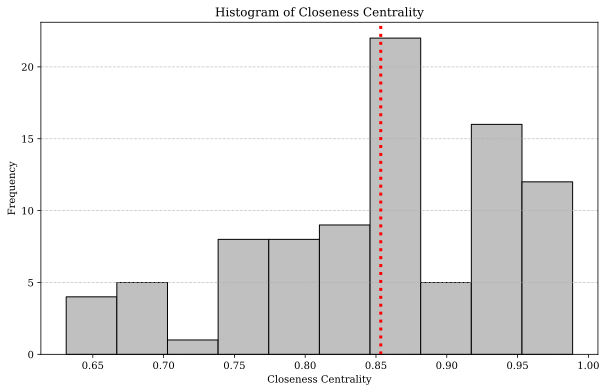

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Convert to DataFrame for easier analysis
centrality_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Node', 'ClosenessCentrality'])

# Summary statistics
summary_stats = centrality_df['ClosenessCentrality'].describe()
print(summary_stats)

# Identify top 5 hubs
top_5_hubs = centrality_df.nlargest(5, 'ClosenessCentrality')
print("Top 5 nodes (closeness centrality):")
print(top_5_hubs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['ClosenessCentrality'], bins=10, edgecolor='black', color = 'silver')
plt.title('Histogram of Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.axvline(x=centrality_df['ClosenessCentrality'].mean(), color='red', label='Mean', linewidth=3, linestyle='dotted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Observation**:
- Distribution: The closeness centrality values range from approximately 0.65 to 1.0.
- Frequency: The most frequent closeness centrality values are around 0.85, with several peaks indicating multiple groups of nodes with varying levels of centrality.
- Range: Closeness centrality values range from approximately 0.65 to 1.0.

**Implication**:
- High Centrality: The skew towards higher closeness centrality values suggests that many nodes are centrally located within the network. These nodes can quickly reach other nodes, contributing to efficient communication.
- Network Efficiency: The presence of many nodes with high closeness centrality, coupled with the very short average shortest path length of 1.18, indicates a highly efficient network. Information can be transferred rapidly across the network.
- Node Distribution: The peaks in the histogram suggest that there are distinct groups or clusters of nodes with similar levels of centrality, indicating a hierarchical structure within the network.

**Network Characteristics**:
- The presence of several peaks suggests that there may be distinct clusters or communities within the brain network that have varying levels of centrality.
- A significant peak around 0.85 in the closeness centrality histogram indicates that a substantial portion of the nodes has high centrality, reflecting their crucial role in facilitating efficient communication across the network. This is a common characteristic in many natural and complex networks where central hubs play a key role in maintaining overall network efficiency.

count    90.000000
mean      0.002117
std       0.001099
min       0.000075
25%       0.001372
50%       0.002072
75%       0.002830
max       0.004450
Name: BetweennessCentrality, dtype: float64
Top 5 nodes (betweenness centrality):
    Node  BetweennessCentrality
75    76               0.004450
35    36               0.004424
74    75               0.004265
33    34               0.004183
71    72               0.004130


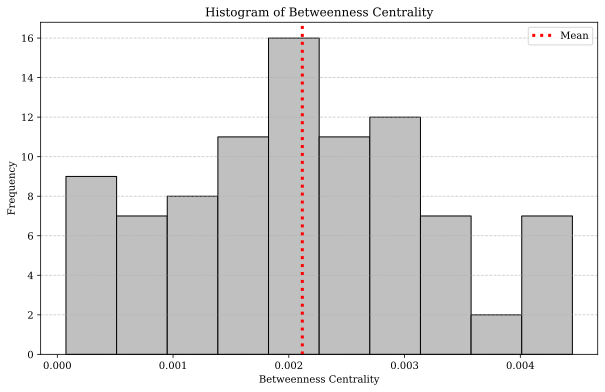

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Convert to DataFrame for easier analysis
centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])

# Summary statistics
summary_stats = centrality_df['BetweennessCentrality'].describe()
print(summary_stats)

# Identify top 5 hubs
top_5_hubs = centrality_df.nlargest(5, 'BetweennessCentrality')
print("Top 5 nodes (betweenness centrality):")
print(top_5_hubs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['BetweennessCentrality'], bins=10, edgecolor='black', color = 'silver')
plt.title('Histogram of Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.axvline(x=centrality_df['BetweennessCentrality'].mean(), color='red', label='Mean', linewidth=3, linestyle='dotted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

count    3259.000000
mean        0.000364
std         0.000077
min         0.000250
25%         0.000314
50%         0.000345
75%         0.000390
max         0.000718
Name: BetweennessCentrality, dtype: float64
Top 5 nodes (betweenness centrality):
          Node  BetweennessCentrality
2140  (40, 76)               0.000718
1332  (22, 36)               0.000713
1847  (34, 40)               0.000707
2139  (40, 74)               0.000706
2141  (40, 78)               0.000706


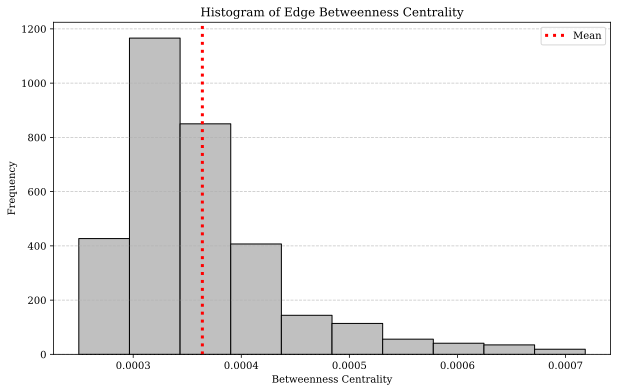

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Compute betweenness centrality
betweenness_centrality = nx.edge_betweenness_centrality(G)

# Convert to DataFrame for easier analysis
centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])

# Summary statistics
summary_stats = centrality_df['BetweennessCentrality'].describe()
print(summary_stats)

# Identify top 5 hubs
top_5_hubs = centrality_df.nlargest(5, 'BetweennessCentrality')
print("Top 5 nodes (betweenness centrality):")
print(top_5_hubs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(centrality_df['BetweennessCentrality'], bins=10, edgecolor='black', color = 'silver')
plt.title('Histogram of Edge Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.axvline(x=centrality_df['BetweennessCentrality'].mean(), color='red', label='Mean', linewidth=3, linestyle='dotted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

**Observations**:
- Distribution: The betweenness centrality values range from approximately 0.000 to 0.004.
- Frequency: The histogram shows a relatively even distribution of betweenness centrality values, with multiple peaks around 0.002 and 0.003.
- Range: Betweenness centrality values range from approximately 0.000 to 0.004.

**Implications**:
- Central Nodes: Nodes with higher betweenness centrality values (around 0.002 to 0.003) play a significant role in facilitating communication between different parts of the network. These nodes act as bridges or intermediaries, ensuring efficient information transfer.
- Network Robustness: The relatively even distribution of betweenness centrality values suggests a well-distributed network where multiple nodes contribute to maintaining efficient communication pathways. This distribution indicates robustness, as the network does not rely excessively on a single or a few nodes for information flow.

**Network Characteristics**:
- The relatively even distribution of betweenness centrality values suggests that the brain network does not rely excessively on a few key nodes, but rather has multiple nodes contributing significantly to maintaining efficient communication pathways.
- This type of distribution indicates a robust and resilient network structure, where multiple nodes play important roles in ensuring connectivity and overall functionality. Such a structure is beneficial in biological networks, as it enhances the network's ability to withstand disruptions or failures of individual nodes.

## General Analysis

In [39]:
# Weighted Graph
patient_data['avg_shortest_path_lenght'] = patient_data['graph_data'].apply(nx.average_shortest_path_length)
patient_data['degree_centrality'] = patient_data['graph_data'].apply(nx.degree_centrality)
patient_data['closeness_centrality'] = patient_data['graph_data'].apply(nx.closeness_centrality)
patient_data['betweenness_centrality'] = patient_data['graph_data'].apply(nx.betweenness_centrality)

patient_data['betweenness_centrality_edge'] = patient_data['graph_data'].apply(nx.edge_betweenness_centrality)

#Unweighted Graph
patient_data['avg_shortest_path_lenght_binary'] = patient_data['graph_data_binary'].apply(nx.average_shortest_path_length)
patient_data['degree_centrality_binary'] = patient_data['graph_data_binary'].apply(nx.degree_centrality)
patient_data['closeness_centrality_binary'] = patient_data['graph_data_binary'].apply(nx.closeness_centrality)
patient_data['betweenness_centrality_binary'] = patient_data['graph_data_binary'].apply(nx.betweenness_centrality)
patient_data['betweenness_centrality_binary_edge'] = patient_data['graph_data_binary'].apply(nx.edge_betweenness_centrality)


## Network Analytics - Multiple Individuals

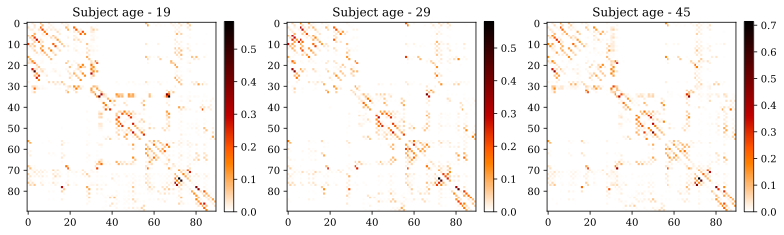

In [94]:
# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1, 3, figsize=(11, 6))  # Adjust the figure size as needed

original_colormap = plt.cm.viridis

# Create an inverted colormap
inverted_colormap = plt.colormaps['gist_heat'].reversed()

subjects = [21,38, 54]

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat ma
    data = patient_data[patient_data.index == subjects[i]]['adj_matrix'][subjects[i]]
    im = ax.imshow(data, cmap=inverted_colormap, interpolation='nearest')

    # Optionally add a colorbar to each subplot
    fig.colorbar(im, ax=ax , fraction=0.046, pad=0.04)

    # Optionally set titles or labels

    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')
    #ax.set_xticks([])  # Remove x-axis ticks
    #ax.set_yticks([])  # Remove y-axis ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


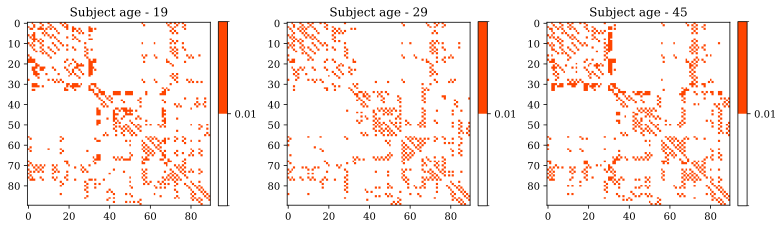

In [83]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(['white', 'orangered'])
bounds = [0, threshold, 1]  # Data range split at 0.01
norm = BoundaryNorm(bounds, cmap.N)

# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1, 3, figsize=(11, 6))  # Adjust the figure size as needed
   
# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat map with custom colormap and normalization
    data = patient_data[patient_data.index == subjects[i]]['adj_matrix'][subjects[i]]
    binary_matrix = (data > threshold).astype(int)
    im = ax.imshow(binary_matrix, cmap=cmap, norm=norm, interpolation='nearest')

    # Add a colorbar to each subplot, using the same norm and cmap
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([threshold])  # Set specific ticks if desired
    cbar.set_ticklabels([str(threshold)])  # Custom labels for the ticks

    # Optionally set titles or labels
    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')
    # ax.set_xticks([])  # Remove x-axis ticks
    # ax.set_yticks([])  # Remove y-axis ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

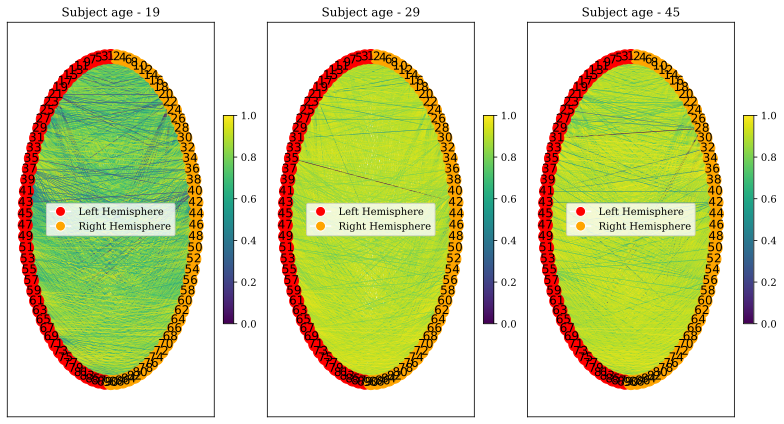

In [42]:
graph_4(graph_type = 'graph_data', subject = [21, 38, 54])

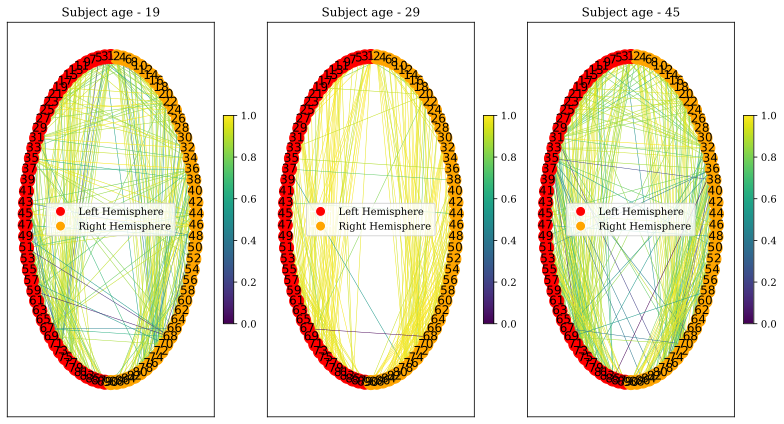

In [43]:
graph_4(graph_type = 'graph_data_binary', subject = [21, 38, 54])

#### Nodes with highest proportion of connections

In [44]:
# Calculate the total weight of connections for each node
subjects = [21,38,  54]

for subject_index in subjects:
    G = patient_data['graph_data'][subject_index]
    node_weights = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes}
    
    # Find the nodes with the highest proportion of connections
    highest_weight_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:5]  # Top 5 nodes
    subject_age = patient_data[patient_data.index == subject_index]['age (years)'][subject_index]

    print(f'Subject {subject_index} - Subject Age {subject_age} - Nodes with highest proportion of connections: {highest_weight_nodes}')

Subject 21 - Subject Age 19 - Nodes with highest proportion of connections: [4, 73, 74, 51, 36]
Subject 38 - Subject Age 29 - Nodes with highest proportion of connections: [4, 3, 73, 7, 8]
Subject 54 - Subject Age 45 - Nodes with highest proportion of connections: [4, 34, 73, 70, 3]


#### Centrality Measures

Plot: Degree Centrality


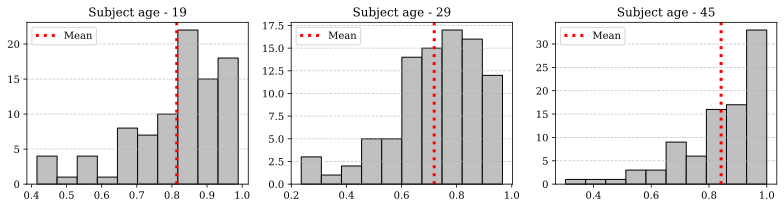

In [45]:
# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1,3 , figsize=(11, 3))  # Adjust the figure size as needed

subjects = [21,38,  54]

top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'DegreeCentrality'])

print('Plot: Degree Centrality')

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat ma
    subject_index = subjects[i]
    G = patient_data['graph_data'][subjects[i]]
    degree_centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'DegreeCentrality'])

    top_5 = centrality_df.nlargest(5, 'DegreeCentrality')
    top_5['Subject'] = subject_index
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)
    
    ax.hist(centrality_df['DegreeCentrality'], bins=10, edgecolor='black', color = 'silver')

        # Adding a vertical line for the mean
    ax.axvline(x=centrality_df.mean()[1], color='red', label='Mean', linewidth=3, linestyle='dotted')
    
    # Grid and other aesthetics
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # Optionally set titles or label
    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [46]:
# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

top_nodes_df

subject_21 subject_38 subject_54
0         36         67         31
1         75         77         32
2         76         78         33
3         34         68         74
4         72         74         77

Plot: Closeness Centrality


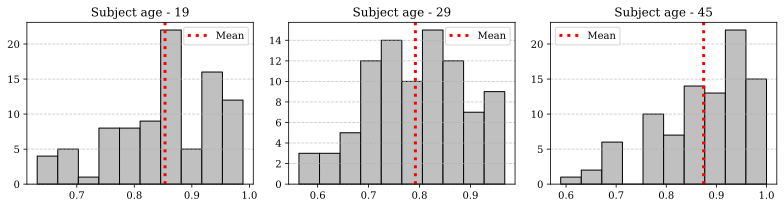

In [47]:
# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1,3 , figsize=(11, 3))  # Adjust the figure size as needed

subjects = [21,38,  54]

top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'ClosenessCentrality'])

print('Plot: Closeness Centrality')

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat ma
    subject_index = subjects[i]
    G = patient_data['graph_data'][subject_index]
    closeness_centrality = nx.closeness_centrality(G)
    centrality_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Node', 'ClosenessCentrality'])

    top_5 = centrality_df.nlargest(5, 'ClosenessCentrality')
    top_5['Subject'] = subject_index
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)
    
    ax.hist(centrality_df['ClosenessCentrality'], bins=10, edgecolor='black', color = 'silver')

        # Adding a vertical line for the mean
    ax.axvline(x=centrality_df.mean()[1], color='red', label='Mean', linewidth=3, linestyle='dotted')
    
    # Grid and other aesthetics
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # Optionally set titles or label
    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [48]:
# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

top_nodes_df

subject_21 subject_38 subject_54
0         36         67         31
1         75         77         32
2         76         78         33
3         34         68         74
4         72         74         77

Plot: Betweenness Centrality


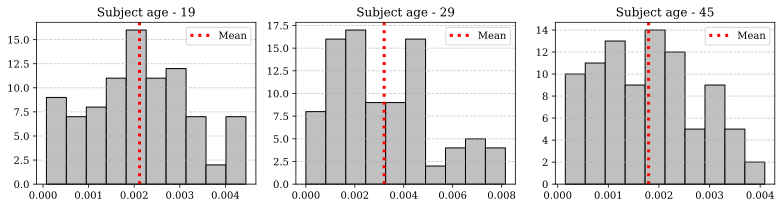

In [49]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Selected subjects (indices in this example)
subjects = [21,38, 54]

# Create a DataFrame to store top 5 nodes for each subject
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

# Create a figure with a 2x2 grid of axes
fig, axes = plt.subplots(1,3 , figsize=(11, 3))  # Adjust the figure size as needed

print('Plot: Betweenness Centrality')

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heatmap
    subject_index = subjects[i]
    G = patient_data['graph_data'][subject_index]
    betweenness_centrality = nx.betweenness_centrality(G)
    centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])
    
    # Get top 5 nodes by betweenness centrality
    top_5 = centrality_df.nlargest(5, 'BetweennessCentrality')
    top_5['Subject'] = subject_index
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)
    
    # Plot the histogram
    ax.hist(centrality_df['BetweennessCentrality'], bins=10, edgecolor='black', color='silver')

    # Adding a vertical line for the mean
    ax.axvline(x=centrality_df.mean()[1], color='red', label='Mean', linewidth=3, linestyle='dotted')
    
    # Grid and other aesthetics
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # Optionally set titles or labels
    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Display the top nodes DataFrame
#top_nodes_df

In [50]:
# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

top_nodes_df

subject_21 subject_38 subject_54
0         76         78         31
1         36         67         32
2         75         74         74
3         34         35         78
4         72         68         73

Plot: Edge Betweenness Centrality


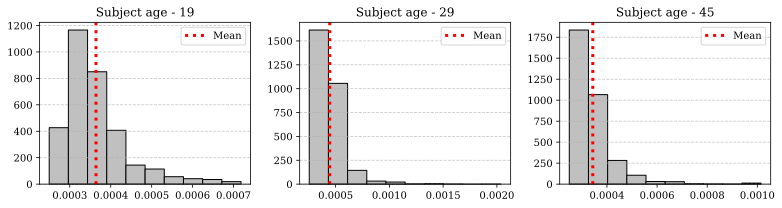

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Selected subjects (indices in this example)
subjects = [21,38, 54]

# Create a DataFrame to store top 5 nodes for each subject
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

# Create a figure with a 2x2 grid of axes
fig, axes = plt.subplots(1,3 , figsize=(11, 3))  # Adjust the figure size as needed

print('Plot: Edge Betweenness Centrality')

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heatmap
    subject_index = subjects[i]
    G = patient_data['graph_data'][subject_index]
    betweenness_centrality = nx.edge_betweenness_centrality(G)
    centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])
    
    # Get top 5 nodes by betweenness centrality
    top_5 = centrality_df.nlargest(5, 'BetweennessCentrality')
    top_5['Subject'] = subject_index
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)
    
    # Plot the histogram
    ax.hist(centrality_df['BetweennessCentrality'], bins=10, edgecolor='black', color='silver')

    # Adding a vertical line for the mean
    ax.axvline(x=centrality_df['BetweennessCentrality'].mean(), color='red', label='Mean', linewidth=3, linestyle='dotted')
    
    # Grid and other aesthetics
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

    # Optionally set titles or labels
    subject_age = patient_data[patient_data.index == subjects[i]]['age (years)'][subjects[i]]
    ax.set_title(f'Subject age - {subject_age}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Display the top nodes DataFrame
#top_nodes_df

In [52]:
# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

top_nodes_df

subject_21 subject_38 subject_54
0   (40, 76)   (35, 42)   (28, 31)
1   (22, 36)   (42, 78)   (28, 73)
2   (34, 40)   (42, 68)   (28, 71)
3   (40, 74)   (21, 35)   (28, 32)
4   (40, 78)   (42, 74)   (28, 86)

## Network Analytics - Group Averaging

In [53]:
group_1_indices = patient_data[patient_data['group_1'] == 1].index.tolist()
group_2_indices = patient_data[patient_data['group_2'] == 1].index.tolist()
group_3_indices = patient_data[patient_data['group_3'] == 1].index.tolist()

In [54]:
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

for i in range(1 , len(patient_data)+1):
    G = patient_data['graph_data'][i]
    degree_centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'DegreeCentrality'])

    top_5 = centrality_df.nlargest(5, 'DegreeCentrality')
    top_5['Subject'] = i
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)


# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
#top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

modes = pd.DataFrame(index=top_nodes_df.index)
for group, indices in zip(['group_1', 'group_2', 'group_3'], [group_1_indices, group_2_indices, group_3_indices]):
    modes[group] = unique_mode(top_nodes_df, indices)

modes

group_1  group_2  group_3
0       74       78       73
1       78       74       74
2       67       67       77
3       68       77       36
4       36        4       68

In [55]:
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

for i in range(1 , len(patient_data)+1):
    G = patient_data['graph_data'][i]
    closeness_centrality = nx.closeness_centrality(G)
    centrality_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Node', 'ClosenessCentrality'])

    top_5 = centrality_df.nlargest(5, 'ClosenessCentrality')
    top_5['Subject'] = i
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)


# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
#top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

# Compute mode for each row by group ensuring no number is reused
modes = pd.DataFrame(index=top_nodes_df.index)
for group, indices in zip(['group_1', 'group_2', 'group_3'], [group_1_indices, group_2_indices, group_3_indices]):
    modes[group] = unique_mode(top_nodes_df, indices)

modes

group_1  group_2  group_3
0       74       78       73
1       78       74       74
2       67       67       77
3       68       77       36
4       36        4       68

In [56]:
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

for i in range(1 , len(patient_data)+1):
    G = patient_data['graph_data'][i]
    betweenness_centrality = nx.betweenness_centrality(G)
    centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])
    # Get top 5 nodes by betweenness centrality
    top_5 = centrality_df.nlargest(5, 'BetweennessCentrality')
    top_5['Subject'] = i
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)


# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
#top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

# Compute mode for each row by group ensuring no number is reused
modes = pd.DataFrame(index=top_nodes_df.index)
for group, indices in zip(['group_1', 'group_2', 'group_3'], [group_1_indices, group_2_indices, group_3_indices]):
    modes[group] = unique_mode(top_nodes_df, indices)

modes

group_1  group_2  group_3
0       74       78       73
1       78       68       74
2       67       67       77
3       68       74       78
4       73       72       71

In [57]:
top_nodes_df = pd.DataFrame(columns=['Subject', 'Node', 'BetweennessCentrality'])

for i in range(1 , len(patient_data)+1):
    G = patient_data['graph_data'][i]
    betweenness_centrality = nx.edge_betweenness_centrality(G)
    centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'BetweennessCentrality'])
    # Get top 5 nodes by betweenness centrality
    top_5 = centrality_df.nlargest(5, 'BetweennessCentrality')
    top_5['Subject'] = i
    top_nodes_df = pd.concat([top_nodes_df, top_5], ignore_index=True)


# Create a DataFrame to store top nodes for each subject
top_nodes_df = top_nodes_df.pivot_table(index=top_nodes_df.groupby('Subject').cumcount(), columns='Subject', values='Node', aggfunc='first')

# Reset index for better readability
top_nodes_df.reset_index(drop=True, inplace=True)

# Rename the columns to include "subject_number"
#top_nodes_df.columns = [f'subject_{col}' for col in top_nodes_df.columns]

# Compute mode for each row by group ensuring no number is reused
modes = pd.DataFrame(index=top_nodes_df.index)
for group, indices in zip(['group_1', 'group_2', 'group_3'], [group_1_indices, group_2_indices, group_3_indices]):
    modes[group] = unique_mode(top_nodes_df, indices)

modes

group_1   group_2   group_3
0  (27, 28)  (22, 71)  (28, 80)
1  (22, 86)  (22, 86)  (21, 73)
2  (28, 31)  (36, 41)  (28, 71)
3  (22, 78)  (41, 67)  (28, 75)
4  (22, 30)  (41, 71)  (41, 86)

### Plots

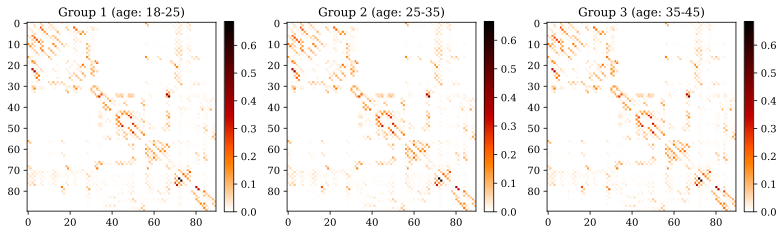

In [72]:
# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1, 3, figsize=(11, 6))  # Adjust the figure size as needed

original_colormap = plt.cm.viridis

# Create an inverted colormap
inverted_colormap = plt.colormaps['gist_heat'].reversed()

subjects = [21,38, 54]

# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat ma
    data = patient_data[patient_data[f'group_{i+1}'] == 1]['adj_matrix'].mean()
    im = ax.imshow(data, cmap=inverted_colormap, interpolation='nearest')

    # Optionally add a colorbar to each subplot
    fig.colorbar(im, ax=ax , fraction=0.046, pad=0.04)

    # Optionally set titles or labels

    subject_ages = ['18-25', '25-35', '35-45']
    subject_age = subject_ages[i]
    ax.set_title(f'Group {i+1} (age: {subject_age})')
    #ax.set_xticks([])  # Remove x-axis ticks
    #ax.set_yticks([])  # Remove y-axis ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

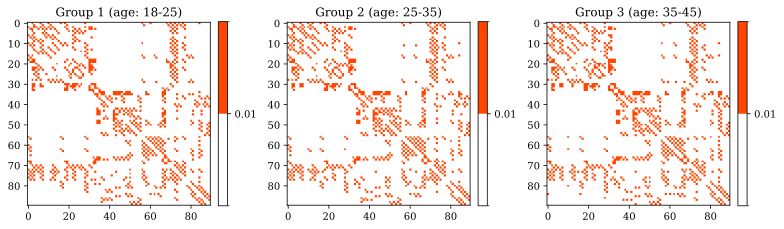

In [73]:
cmap = ListedColormap(['white', 'orangered'])
bounds = [0, threshold, 1]  # Data range split at 0.01
norm = BoundaryNorm(bounds, cmap.N)

# Create a figure with a 3x3 grid of axes
fig, axes = plt.subplots(1, 3, figsize=(11, 6))  # Adjust the figure size as needed
   
# Loop over the grid and fill in the subplots
for i, ax in enumerate(axes.flatten()):
    # Plot the heat map with custom colormap and normalization
    data = patient_data[patient_data[f'group_{i+1}'] == 1]['adj_matrix'].mean()
    binary_matrix = (data > threshold).astype(int)
    im = ax.imshow(binary_matrix, cmap=cmap, norm=norm, interpolation='nearest')

    # Add a colorbar to each subplot, using the same norm and cmap
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([threshold])  # Set specific ticks if desired
    cbar.set_ticklabels([str(threshold)])  # Custom labels for the ticks

    # Optionally set titles or labels
    subject_ages = ['18-25', '25-35', '35-45']
    subject_age = subject_ages[i]
    ax.set_title(f'Group {i+1} (age: {subject_age})')
    # ax.set_xticks([])  # Remove x-axis ticks
    # ax.set_yticks([])  # Remove y-axis ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

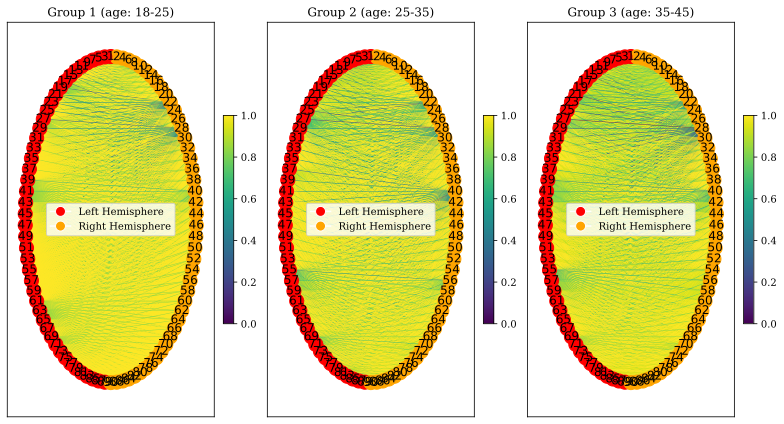

In [60]:
graph_4_avg()

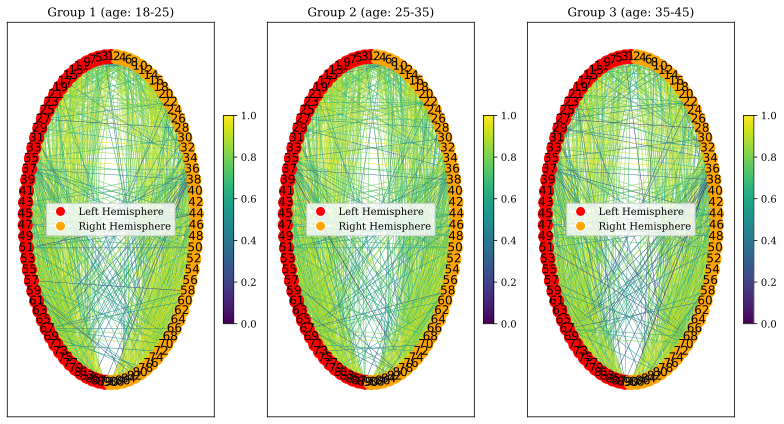

In [61]:
graph_4_avg(graph_type = 'graph_binary')

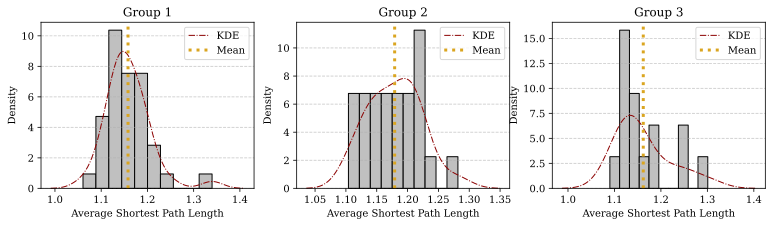

In [84]:
plot_histogram_kde_avg(patient_data, 'avg_shortest_path_lenght')

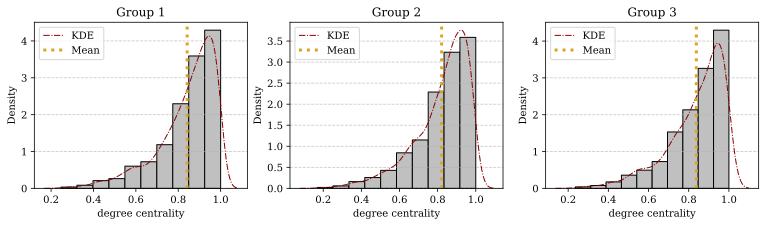

In [85]:
plot_histogram_kde(patient_data, 'degree_centrality')

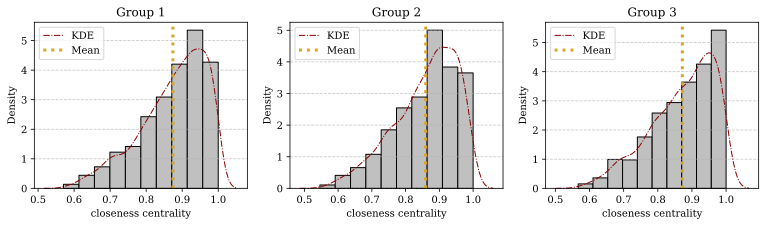

In [86]:
plot_histogram_kde(patient_data, 'closeness_centrality')

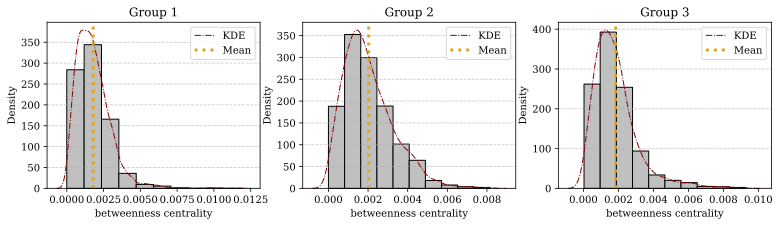

In [87]:
plot_histogram_kde(patient_data, 'betweenness_centrality')

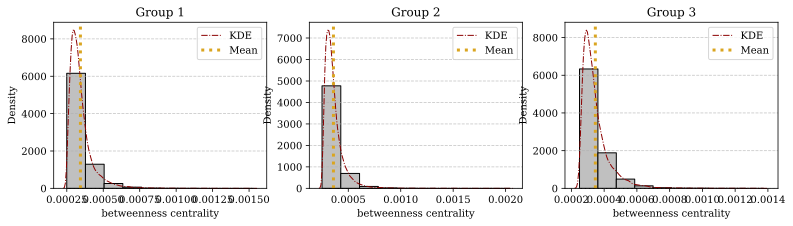

In [88]:
plot_histogram_kde(patient_data, 'betweenness_centrality_edge')

#### Unweighted Graphs

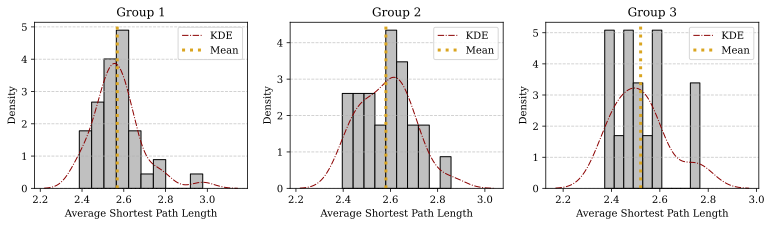

In [89]:
plot_histogram_kde_avg(patient_data, 'avg_shortest_path_lenght_binary')

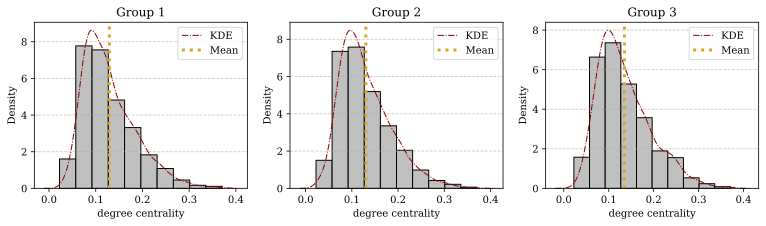

In [90]:
plot_histogram_kde(patient_data, 'degree_centrality_binary')

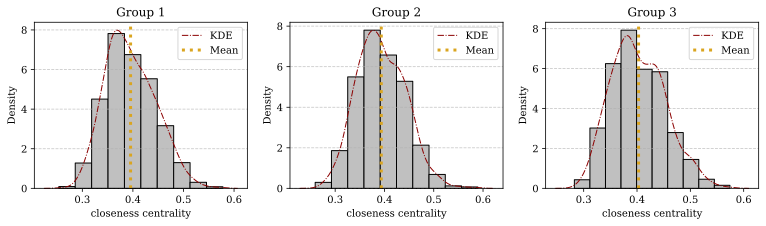

In [91]:
plot_histogram_kde(patient_data, 'closeness_centrality_binary')

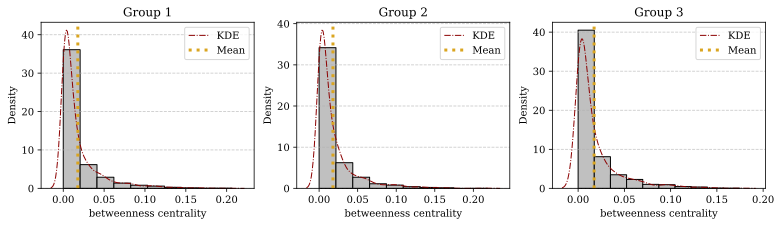

In [92]:
plot_histogram_kde(patient_data, 'betweenness_centrality_binary')

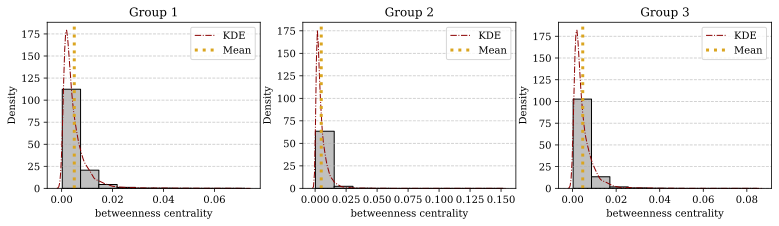

In [93]:
plot_histogram_kde(patient_data, 'betweenness_centrality_binary_edge')